## Data Acquisition ##

To obtain our CSV and JSON datasets, we went to the website source (linked in references) and downloaded the raw data files. We then checked to ensure that the downloaded file matched the original file from the website. We did not need to perform the checksums because our data is taken from organizations that have a license that allows us to freely use and modify without restriction. 

CSV Licence:
This dataset is licensed under a Creative Commons Attribution 4.0 International (CC BY 4.0) license. The original data set (hosted at https://www.synapse.org/#!Synapse:syn4301332) is maintained by the cancer genome atlas pan-cancer analysis project.

JSON License:
The dataset is distributed under the Creative Commons Attribution 4.0 International (CC BY 4.0) license, permitting sharing and adaptation for any purpose, provided appropriate credit is given to the original creator, Samuele Fiorini.


## Data Integration ##

To integrate these files, we need a common key or an identifier linking the datasets. However, the JSON file appears to describe metadata rather than directly containing patient-specific identifiers or data points. Therefore, we decided to proceed by adding JSON metadata to enrich the CSV. 


### Steps: ###

1. After loading the json and csv file, we extracted specfic fields (resourceType, id, name, title, description) from the json data using the .get() method. If a field was missing in the JSON file, it defaults to an empty string ("").
2. Converts the extracted metadata dictionary into a Pandas DataFrame for easier handling.
3. To enrich the CSV data, we added the metadata field as new columns to the csv_data Dataframe. Each column in the csv_data corresponds to a metadata field (resourceType, id, etc.). The value for each new column is the same across all rows, as it comes directly from the metadata dictionary.
4. Lastly, we saved the updated csv_data DataFrame to a new CSV file located at output/enriched_gene_expression.csv.

In [1]:
import json 
import pandas as pd

json_file_path = '/Users/kaylamoy/Desktop/is477-fa24-chamoy/JSON/original-cancer-patient.json'
with open(json_file_path, 'r') as file:
    json_data = json.load(file)

csv_file_path = '/Users/kaylamoy/Desktop/is477-fa24-chamoy/CSV/gene-expression.csv.gz'
csv_data = pd.read_csv(csv_file_path) 

metadata = {
    "resourceType": json_data.get("resourceType", ""),
    "id": json_data.get("id", ""),
    "name": json_data.get("name", ""),
    "title": json_data.get("title", ""),
    "description": json_data.get("description", "")
}

metadata_df = pd.DataFrame([metadata])


for key, value in metadata.items():
    csv_data[key] = value

output_file_path = 'output/enriched_gene_expression.csv'
csv_data.to_csv(output_file_path, index=False)

output_file_path

'output/enriched_gene_expression.csv'

## Profiling, Quality Assesment, Cleaning Data ##

### Steps ###

1. In order to profile the data, we used data.info() to help identify columns with missing or inconsistent data. By using data.describe(include='all'), it generated a summary statistic for all columns. This was useful for understanding data distributions (mean, min, max, etc.) and detecting potential anomalies. 

2. To asses the data quality, we checked for missing values using data.isnull().sum(), which calculates the number of missing values in each column and highlights columns that need to be cleaned or imputed. The function
data.duplicated().sum() is used to check for duplicate rows in the dataset.

3. By cleaning the data, we removed duplicates by using data.drop_duplicates(). This ensures that each observation in the dataset is unique. We also used data.fillna("Unknown") to handle missing values and fills in the blanks with "Unknown". This ensures that no empty cells remain, which could cause errors in downstream analysis.


4. Once the data was cleaned, we saved the new data as a new CSV file (output/cleaned_enriched_gene_expression.csv) using data_cleaned.to_csv(). We used this cleaned data for further analysis and visualization.

In [2]:
file_path = "output/enriched_gene_expression.csv"
data = pd.read_csv(file_path)

print("Dataset Overview:")
print(data.info())  

print("\nSummary Statistics:")
print(data.describe(include='all'))  

# Step 2: Assessing Data Quality
missing_values = data.isnull().sum()  
print("\nMissing Values:")
print(missing_values)

duplicates = data.duplicated().sum()  
print(f"\nNumber of duplicate rows: {duplicates}")

# Step 3: Cleaning Data
data_cleaned = data.drop_duplicates()

data_cleaned = data_cleaned.fillna("Unknown")

output_cleaned_file_path = "output/cleaned_enriched_gene_expression.csv"
data_cleaned.to_csv(output_cleaned_file_path, index=False)
print(f"\nCleaned data saved to {output_cleaned_file_path}")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 16389 entries, Class to description
dtypes: float64(16351), int64(32), object(6)
memory usage: 100.2+ MB
None

Summary Statistics:
       Class      gene_0      gene_1      gene_2      gene_3      gene_4  \
count    801  801.000000  801.000000  801.000000  801.000000  801.000000   
unique     5         NaN         NaN         NaN         NaN         NaN   
top     BRCA         NaN         NaN         NaN         NaN         NaN   
freq     300         NaN         NaN         NaN         NaN         NaN   
mean     NaN    0.026642    3.010909    3.095350    6.722305    9.813612   
std      NaN    0.136850    1.200828    1.065601    0.638819    0.506537   
min      NaN    0.000000    0.000000    0.000000    5.009284    8.435999   
25%      NaN    0.000000    2.299039    2.390365    6.303346    9.464466   
50%      NaN    0.000000    3.143687    3.127006    6.655893    9.791599   
75%      N

In [8]:
operations = [
  {
    "op": "core/column-rename",
    "description": "Rename column Class",
    "oldColumnName": "Class",
    "newColumnName": "class"
  },
  {
    "op": "core/text-transform",
    "description": "Replace empty values in Description column",
    "engineConfig": {
      "mode": "row-based",
      "facets": []
    },
    "columnName": "description",
    "expression": "value==null ? 'Unknown' : value",
    "onError": "keep-original"
  },
  {
    "op": "core/remove-duplicates",
    "description": "Remove duplicate rows"
  }
]

file_path = "openrefine_operations.json"
with open(file_path, "w") as f:
    json.dump(operations, f, indent=2)

print(f"JSON operations saved to {file_path}")

JSON operations saved to openrefine_operations.json


**CSV - Gene Expression**

Cleaned Data with a Heatmap visualization

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/Users/kaylamoy/Desktop/is477-fa24-chamoy/CSV/cleaned_gene_expression.csv'
data = pd.read_csv('output/cleaned_enriched_gene_expression.csv')
data.head()

,Class,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_16378,gene_16379,gene_16380,gene_16381,gene_16382,resourceType,id,name,title,description
0,PRAD,0.0,2.017209,3.265527,5.478487,10.431999,0,7.175175,0.591871,0.0,...,3.973382,0.000000,9.291933,0.840926,7.886642,StructureDefinition,mcode-cancer-patient,CancerPatient,Cancer Patient Profile,A patient who has been diagnosed with or is re...
1,LUAD,0.0,0.592732,1.588421,7.586157,9.623011,0,6.816049,0.000000,0.0,...,3.255773,1.590818,3.467410,1.178045,8.864223,StructureDefinition,mcode-cancer-patient,CancerPatient,Cancer Patient Profile,A patient who has been diagnosed with or is re...
2,PRAD,0.0,3.511759,4.327199,6.881787,9.870730,0,6.972130,0.452595,0.0,...,0.796598,0.000000,5.533710,0.225892,9.843799,StructureDefinition,mcode-cancer-patient,CancerPatient,Cancer Patient Profile,A patient who has been diagnosed with or is re...
3,PRAD,0.0,3.663618,4.507649,6.659068,10.196184,0,7.843375,0.434882,0.0,...,1.039419,0.000000,8.358278,0.377401,7.701320,StructureDefinition,mcode-cancer-patient,CancerPatient,Cancer Patient Profile,A patient who has been diagnosed with or is re...
4,BRCA,0.0,2.655741,2.821547,6.539454,9.738265,0,6.566967,0.360982,0.0,...,0.360982,0.649386,9.315607,1.052833,10.646325,StructureDefinition,mcode-cancer-patient,CancerPatient,Cancer Patient Profile,A patient who has been diagnosed with or is re...


/var/folders/0s/47wy4dnn395c9sl8t6pbgtnm0000gn/T/ipykernel_4449/1986254080.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_expression_per_class = cleaned_data.groupby('Class').mean()


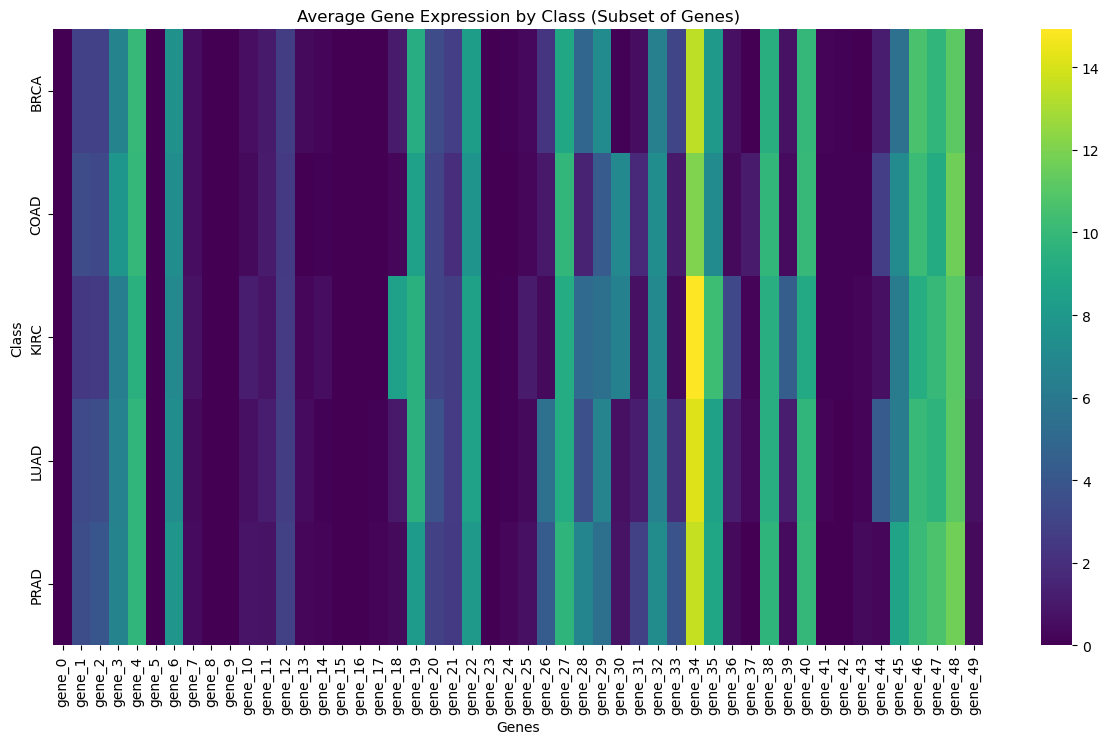

In [21]:
#Heatmap Visualization
missing_values = data.isnull().sum().sum()
cleaned_data = data.dropna() if missing_values > 0 else data

#mean expression levels for each gene grouped by "Class"
mean_expression_per_class = cleaned_data.groupby('Class').mean()

#First 50 genes
subset_genes = mean_expression_per_class.iloc[:, :50]

plt.figure(figsize=(15, 8))
sns.heatmap(subset_genes, cmap="viridis", annot=False)
plt.title("Average Gene Expression by Class (Subset of Genes)")
plt.xlabel("Genes")
plt.ylabel("Class")
plt.savefig("visualizations/heatmap.png")
plt.show()

**JSON - Cancer Patient Data**

Cleaned data with a stacked bar chart

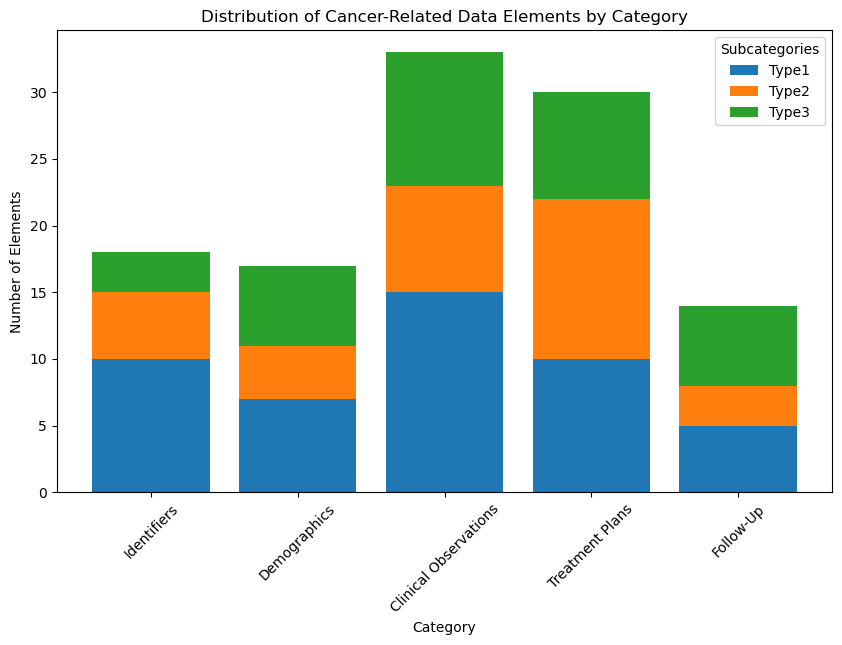

In [20]:
# Stacked Bar Chart Visualization for Key Cancer-Related Categories
import numpy as np

category_data = {
    "Identifiers": [10, 5, 3],        
    "Demographics": [7, 4, 6],         
    "Clinical Observations": [15, 8, 10],  
    "Treatment Plans": [10, 12, 8],   
    "Follow-Up": [5, 3, 6]            
}

categories = list(category_data.keys())
counts = np.array(list(category_data.values()))
subcategories = ["Type1", "Type2", "Type3"] 

fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(categories))

for idx, subcategory in enumerate(subcategories):
    ax.bar(categories, counts[:, idx], label=subcategory, bottom=bottom)
    bottom += counts[:, idx]

ax.set_title("Distribution of Cancer-Related Data Elements by Category")
ax.set_xlabel("Category")
ax.set_ylabel("Number of Elements")
ax.legend(title="Subcategories")
plt.xticks(rotation=45)
plt.savefig("visualizations/barchart.png")
plt.show()

## Package Development for Reproducibility ##

## Automated Workflow Setup ##